In [2]:
import gensim.downloader as api

# Load the Google News Word2Vec model
wv_pretrained = api.load('word2vec-google-news-300')

In [3]:
import pandas as pd
import kagglehub

# Download the dataset
dataset_path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

print("Path to dataset files:", dataset_path)

# Usually, the CSV is named IMDB Dataset.csv inside the downloaded folder
file_path = dataset_path + "/IMDB Dataset.csv"

# Now load it
df = pd.read_csv(file_path)

# Now you can inspect the data
print(df.head())
print(df['sentiment'].value_counts())


c:\Users\perei\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\perei\.cache\kagglehub\datasets\lakshmi25npathi\imdb-dataset-of-50k-movie-reviews\versions\1
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
positive    25000
negative    25000
Name: sentiment, dtype: int64


<Axes: >

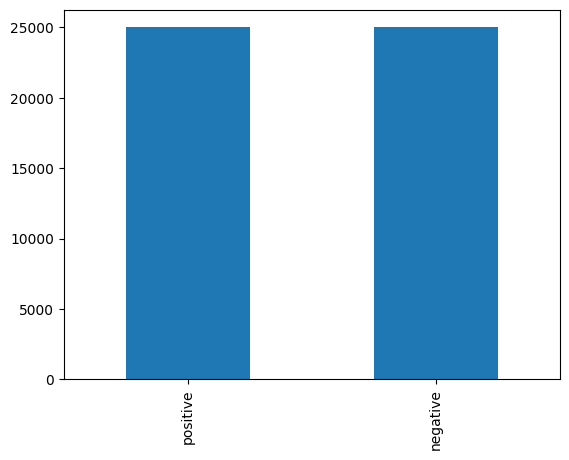

In [4]:
df['sentiment'].value_counts().plot(kind='bar')

count    50000.000000
mean       231.156940
std        171.343997
min          4.000000
25%        126.000000
50%        173.000000
75%        280.000000
max       2470.000000
Name: review_length, dtype: float64


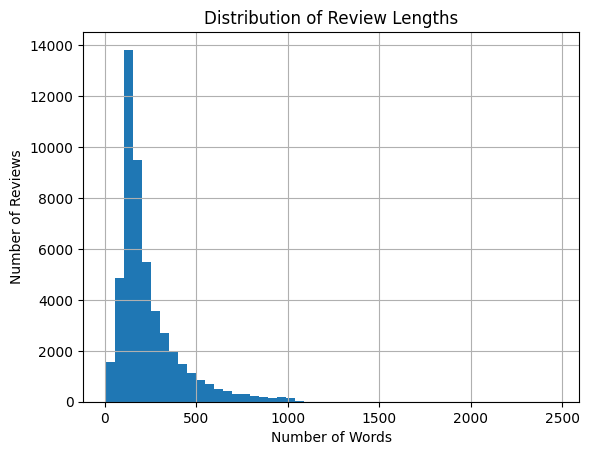

In [5]:
df['review_length'] = df['review'].apply(lambda x: len(x.split()))
print(df['review_length'].describe())

import matplotlib.pyplot as plt
df['review_length'].hist(bins=50)
plt.title("Distribution of Review Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Number of Reviews")
plt.show()


In [6]:
import nltk
import re
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)  # remove HTML tags
    text = re.sub(r'[^a-z\s]', '', text)  # keep only letters
    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_words]
    return tokens

df['tokens'] = df['review'].apply(clean_text)
print(df.head())


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\perei\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                              review sentiment  review_length  \
0  One of the other reviewers has mentioned that ...  positive            307   
1  A wonderful little production. <br /><br />The...  positive            162   
2  I thought this was a wonderful way to spend ti...  positive            166   
3  Basically there's a family where a little boy ...  negative            138   
4  Petter Mattei's "Love in the Time of Money" is...  positive            230   

                                              tokens  
0  [one, reviewers, mentioned, watching, oz, epis...  
1  [wonderful, little, production, filming, techn...  
2  [thought, wonderful, way, spend, time, hot, su...  
3  [basically, theres, family, little, boy, jake,...  
4  [petter, matteis, love, time, money, visually,...  


In [7]:
from gensim.models import Word2Vec

skipgram_model = Word2Vec(
    sentences=df['tokens'],
    vector_size=100,
    window=5,
    min_count=2,
    sg=1,  # skipgram
    workers=4
)


In [8]:
cbow_model = Word2Vec(
    sentences=df['tokens'],
    vector_size=100,
    window=5,
    min_count=2,
    sg=0,  # CBoW
    workers=4
)


In [9]:
from gensim.models import FastText

fasttext_model = FastText(
    sentences=df['tokens'],
    vector_size=100,
    window=5,
    min_count=2,
    sg=1,  # skipgram FastText
    workers=4
)


In [10]:
import numpy as np

def get_average_vector(tokens, model, vector_size):
    vectors = []
    # If model has .wv, use that
    if hasattr(model, 'wv'):
        for t in tokens:
            if t in model.wv:
                vectors.append(model.wv[t])
    else:
        for t in tokens:
            if t in model:
                vectors.append(model[t])
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(vector_size)


df['w2v_vector'] = df['tokens'].apply(lambda x: get_average_vector(x, skipgram_model, 100))
df['cbow_vector'] = df['tokens'].apply(lambda x: get_average_vector(x, cbow_model, 100))
df['fasttext_vector'] = df['tokens'].apply(lambda x: get_average_vector(x, fasttext_model, 100))

# For pre-trained Google News
df['pretrained_vector'] = df['tokens'].apply(lambda x: get_average_vector(x, wv_pretrained, 300))


In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def train_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    clf = LogisticRegression(max_iter=1000)
    clf.fit(list(X_train), y_train)
    preds = clf.predict(list(X_test))
    return accuracy_score(y_test, preds)

# Encode labels
df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0})

acc_pretrained = train_model(df['pretrained_vector'], df['label'])
acc_skipgram = train_model(df['w2v_vector'], df['label'])
acc_cbow = train_model(df['cbow_vector'], df['label'])
acc_fasttext = train_model(df['fasttext_vector'], df['label'])

print(f"Pre-trained W2V Accuracy: {acc_pretrained:.4f}")
print(f"Custom Skipgram Accuracy: {acc_skipgram:.4f}")
print(f"Custom CBoW Accuracy: {acc_cbow:.4f}")
print(f"Custom FastText Accuracy: {acc_fasttext:.4f}")


Pre-trained W2V Accuracy: 0.8511
Custom Skipgram Accuracy: 0.8750
Custom CBoW Accuracy: 0.8598
Custom FastText Accuracy: 0.8738
